# **CityPerson Dataset EDA (Exploratory Data Analysis)**
A complete EDA (Exploratory Data Analysis) for CityPerson dataset

## Used Dataset:

*   gtBbox_trainvaltest
*   gtFinePanopticParts_trainval


Kaggle dataset link: https://www.kaggle.com/datasets/rezaazariaghouieh/cityperson-dataset

## Step 1: Extract and read the datasets

In [32]:
# Import Required Libraries
import os
import cv2
import json
import random
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict

In [33]:
# Dataset source files path from in Kaggle
#gtFine_Src = '***'
gtFinePano_Src = '/kaggle/input/city-persone/gtFinePanopticParts_trainval'
gtBbox_Src = '/kaggle/input/city-persone/gtBbox_cityPersons_trainval'

In [34]:
# List the source content from both datasets
#gtFine_Files = os.listdir(gtFine_ExtPath)
gtFinepano_Files = os.listdir(gtFinePano_Src)
gtBbox_Files = os.listdir(gtBbox_Src)

#gtFine_Files
gtFinepano_Files, gtBbox_Files

(['gtFinePanopticParts', 'README_panopticParts.md', 'license.txt'],
 ['gtBboxCityPersons', 'README_cityPersons', 'license.txt'])

In [35]:
# Path to core folder
# Construct the subdirectory paths
#gtFine_Subdir = os.path.join(gtFine_Src, 'gtFine')
gtBbox_Subdir = os.path.join(gtBbox_Src, 'gtBboxCityPersons')
gtFinePano_Subdir = os.path.join(gtFinePano_Src, 'gtFinePanopticParts')


# List driectories inside core folders
#gtFine_Dirs = os.listdir(gtFine_Subdir) if os.path.exists(gtFine_Subdir) else []
gtBbox_Dirs = os.listdir(gtBbox_Subdir) if os.path.exists(gtBbox_Subdir) else []
gtFinePano_Dirs = os.listdir(gtFinePano_Subdir) if os.path.exists(gtFinePano_Subdir) else []

#gtFine_Dirs
gtBbox_Dirs, gtFinePano_Dirs

(['val', 'train'], ['val', 'train'])

In [36]:
# Define the subdirectories
subdirs = gtBbox_Dirs #["train", "val", "test"]

# Initialize dictionaries to store samples from each subdirectory
#gtFine_CityFolders = {}
gtFinePano_CityFolders = {}
gtBbox_CityFolders = {}

# Process each subdirectory
for subdir in subdirs:
    #gtFine_CityFolders[subdir] = os.listdir(os.path.join(gtFine_CorePath, subdir)) if subdir in gtFine_Dirs else []
    gtFinePano_CityFolders[subdir] = os.listdir(os.path.join(gtFinePano_Subdir, subdir)) if subdir in gtFinePano_Dirs else []
    gtBbox_CityFolders[subdir] = os.listdir(os.path.join(gtBbox_Subdir, subdir)) if subdir in gtBbox_Dirs else []

# Output the first few files for each subdirectory
#gtFine_CityFolders_Preview = {key: value[:] for key, value in gtFine_CityFolders.items()}
gtFinePano_CityFolders_Preview = {key: value[:] for key, value in gtFinePano_CityFolders.items()}
gtBbox_CityFolders_Preview = {key: value[:] for key, value in gtBbox_CityFolders.items()}

#print(gtFine_CityFolders_Preview)
print(gtFinePano_CityFolders_Preview, "\n")
print(gtBbox_CityFolders_Preview)

{'val': ['munster', 'lindau', 'frankfurt'], 'train': ['dusseldorf', 'darmstadt', 'tubingen', 'erfurt', 'bochum', 'krefeld', 'weimar', 'bremen', 'aachen', 'hamburg', 'monchengladbach', 'hanover', 'zurich', 'jena', 'stuttgart', 'strasbourg', 'cologne', 'ulm']} 

{'val': ['munster', 'lindau', 'frankfurt'], 'train': ['dusseldorf', 'darmstadt', 'tubingen', 'erfurt', 'bochum', 'krefeld', 'weimar', 'bremen', 'aachen', 'hamburg', 'monchengladbach', 'hanover', 'zurich', 'jena', 'stuttgart', 'strasbourg', 'cologne', 'ulm']}


## Dataset Structure:

1. gtBbox_trainvaltest
* Contains annotation JSON files.
  * Organized by: Train, and validation folders.
  * Files Type:
      * *_gtBboxCityPersons.json: Contains annotations for semantic segmentation, instance
2. gtFinePanopticParts_trainval:
    * Contains TIF files.
    * Organized similarly to gtBbox_trainvaltest.
    * File type:
      * *_gtFinePanopticParts.tif: Panoptic segmentation with part-level annotations (e.g., parts of a pedestrian like arms or legs).

In [37]:
# Count the distribution of file types in a given directory
def count_file_types(directory):
    if not os.path.exists(directory):
      print(f"Error: Directory '{directory}' not found.")
      return None

    file_type_counts = Counter()
    for root, _, files in os.walk(directory):
        for file in files:
            ext = os.path.splitext(file)[-1].lower()
            file_type_counts[ext] += 1
    return file_type_counts

# # File type distribution for gtFine dataset
# print("File Type Distribution in gtFine Dataset:")
# gtFine_file_types = count_file_types(gtFine_CorePath)
# print(pd.DataFrame(gtFine_file_types.items(), columns=["File Type", "Count"]))

# Analyze file type distribution for gtFinePanopticParts dataset
print("\nFile Type Distribution in gtFinePanopticParts Dataset:")
gtFinePano_file_types = count_file_types(gtFinePano_Subdir)
print(pd.DataFrame(gtFinePano_file_types.items(), columns=["File Type", "Count"]))

# Analyze file type distribution for gtBboxCityPersons dataset
print("\nFile Type Distribution in gtBboxCityPersons Dataset:")
gtBbox_file_types = count_file_types(gtBbox_Subdir)
print(pd.DataFrame(gtBbox_file_types.items(), columns=["File Type", "Count"]))


File Type Distribution in gtFinePanopticParts Dataset:
  File Type  Count
0      .tif   3475

File Type Distribution in gtBboxCityPersons Dataset:
  File Type  Count
0     .json   3475


In [38]:
# Count images in each city folder
def count_images_in_cities(base_path):
    city_counts = {}
    if os.path.exists(base_path):
        for city in os.listdir(base_path):
            city_path = os.path.join(base_path, city)
            if os.path.isdir(city_path):
                image_count = len(os.listdir(city_path))
                city_counts[city] = (image_count, int(image_count / 4))
    return city_counts

# Count images in 'train' and 'val' splits for both datasets
#gtFine_train_counts = count_images_in_cities(os.path.join(gtFine_Subdir, "train"))
#gtFine_val_counts = count_images_in_cities(os.path.join(gtFine_Subdir, "val"))
#gtFine_test_counts = count_images_in_cities(os.path.join(gtFine_Subdir, "test"))
gtFinePano_train_counts = count_images_in_cities(os.path.join(gtFinePano_Subdir, "train"))
gtFinePano_val_counts = count_images_in_cities(os.path.join(gtFinePano_Subdir, "val"))
gtBbox_train_counts = count_images_in_cities(os.path.join(gtBbox_Subdir, "train"))
gtBbox_val_counts = count_images_in_cities(os.path.join(gtBbox_Subdir, "val"))

# # Create PANDAS dataframe for gtFine_CityPersons dataset
# print("Name of the cities and number of unique IDs per city in gtFine dataset:")
# # Save city image counts for gtFine dataset in pandas DataFrame
# gtFine_city_trainImg_pd = pd.DataFrame([(city, count[0], count[1]) for city, count in gtFine_train_counts.items()], columns=["City", "FileCounts", "ImgPerUniqueID"])
# gtFine_city_valImg_pd = pd.DataFrame([(city, count[0], count[1]) for city, count in gtFine_val_counts.items()], columns=["City", "FileCounts", "ImgPerUniqueID"])
# gtFine_city_testImg_pd = pd.DataFrame([(city, count[0], count[1]) for city, count in gtFine_test_counts.items()], columns=["City", "FileCounts", "ImgPerUniqueID"])

# # Print the gtFine DataFrame
# print(gtFine_city_trainImg_pd)
# print(gtFine_city_valImg_pd)
# print(gtFine_city_testImg_pd)

# Creat PANDAS dataframe for GtBbox_CityPersons dataset
print("\nName of the cities and number of unique IDs per city in gtBbox_CityPerson dataset:")
# Save city image counts for gtBbox dataset in pandas DataFrame
gtBbox_city_trainImg_pd = pd.DataFrame([(city, count[0]) for city, count in gtBbox_train_counts.items()], columns=["City", "FileCounts"])
gtBbox_city_valImg_pd = pd.DataFrame([(city, count[0]) for city, count in gtBbox_val_counts.items()], columns=["City", "FileCounts"])

# Print the gtBbox_CityPersons Dataframe
print(gtBbox_city_trainImg_pd)
print(gtBbox_city_valImg_pd)


print("\nName of the cities and number of unique IDs per city in gtFinePanopticParts dataset:")
# Save city image counts for gtFinePanopticParts dataset in pandas DataFrame
gtFinePano_city_trainImg_pd = pd.DataFrame([(city, count[0]) for city, count in gtFinePano_train_counts.items()], columns=["City", "ImageCounts"])
gtFinePano_city_valImg_pd = pd.DataFrame([(city, count[0]) for city, count in gtFinePano_val_counts.items()], columns=["City", "ImageCounts"])

# Print the gtFinePanopticParts DataFrame
print(gtFinePano_city_trainImg_pd)
print(gtFinePano_city_valImg_pd)


Name of the cities and number of unique IDs per city in gtBbox_CityPerson dataset:
               City  FileCounts
0        dusseldorf         221
1         darmstadt          85
2          tubingen         144
3            erfurt         109
4            bochum          96
5           krefeld          99
6            weimar         142
7            bremen         316
8            aachen         174
9           hamburg         248
10  monchengladbach          94
11          hanover         196
12           zurich         122
13             jena         119
14        stuttgart         196
15       strasbourg         365
16          cologne         154
17              ulm          95
        City  FileCounts
0    munster         174
1     lindau          59
2  frankfurt         267

Name of the cities and number of unique IDs per city in gtFinePanopticParts dataset:
               City  ImageCounts
0        dusseldorf          221
1         darmstadt           85
2          tubingen    

## Files structure

For example: the file structure in the "bochum" city directory confirms the expected dataset formats and relationships:
1. gtBbox Dataset (bochum):
    - Files include:
       - Polygon annotations (e.g., bochum_000000_000313_gtFine_polygons.json).


2. gtFinePanopticParts Dataset (bochum):
    - Files include:
      - Panoptic segmentation with part-level detail (e.g., bochum_000000_000313_gtFinePanopticParts.tif).

## Observed Relationship:
- The filenames match across datasets, indicating alignment.
  - For example: bochum_000000_000313_gtFinePanopticParts.tif aligns with the corresponding files in gtFine for color, instance, label, and polygons.

In [39]:
# Validate image and annotation files

# Select 3 cities name randomly from 'train' folder to check files
selected_cities = random.sample(gtBbox_CityFolders['train'], 3)

# List files for each selected city
#gtFine_city_files = {}
gtFinePano_city_files = {}
gtBbox_city_files = {}
#gtFine_city_files_sorted = {}
gtFinePano_city_files_sorted = {}
gtBbox_city_files_sorted = {}

for city in selected_cities:
    #gtFine_city_path = os.path.join(gtFine_subdir, "train", city)
    gtFinePano_city_path = os.path.join(gtFinePano_Subdir, "train", city)
    gtBbox_city_path = os.path.join(gtBbox_Subdir, "train", city)

    #gtFine_city_files[city] = sorted(os.listdir(gtFine_city_path) if os.path.exists(gtFine_city_path) else [])
    gtFinePano_city_files[city] = sorted(os.listdir(gtFinePano_city_path) if os.path.exists(gtFinePano_city_path) else [])
    gtBbox_city_files[city] = sorted(os.listdir(gtBbox_city_path) if os.path.exists(gtBbox_city_path) else [])

    #gtFine_city_files_sorted[city] = gtFine_city_files[city][:4]
    gtFinePano_city_files_sorted[city] = gtFinePano_city_files[city][:1]
    gtBbox_city_files_sorted[city] = gtBbox_city_files[city][:1]

# Preview sample files for each city
#gtFine_city_files_sorted, 
gtFinePano_city_files_sorted, gtBbox_city_files_sorted

({'erfurt': ['erfurt_000000_000019_gtFinePanopticParts.tif'],
  'krefeld': ['krefeld_000000_000108_gtFinePanopticParts.tif'],
  'darmstadt': ['darmstadt_000000_000019_gtFinePanopticParts.tif']},
 {'erfurt': ['erfurt_000000_000019_gtBboxCityPersons.json'],
  'krefeld': ['krefeld_000000_000108_gtBboxCityPersons.json'],
  'darmstadt': ['darmstadt_000000_000019_gtBboxCityPersons.json']})

In [40]:
# Verify that all files (images and annotations) can be opened without errors.
def check_corrupted_images(base_path):
    corrupted_files = []
    for root, _, files in os.walk(base_path):
        for file in files:
            try:
                file_path = os.path.join(root, file)
                if file.lower().endswith(('.png', '.tif')):
                    with Image.open(file_path) as img:
                        img.verify()  # Check for corrupted images
            except Exception as e:
                corrupted_files.append(file_path)
    return corrupted_files

# Check for corrupted files in gtFine and gtFinePanopticParts
#corrupted_gtFine = check_corrupted_images(gtFine_CorePath)
corrupted_gtFinePanopticParts = check_corrupted_images(gtFinePano_Subdir)
corrupted_gtBbox = check_corrupted_images(gtBbox_Subdir)

#print("Corrupted files in gtFine dataset:", corrupted_gtFine)
print("Corrupted files in gtFinePanopticParts dataset:", corrupted_gtFinePanopticParts)
print("Corrupted files in gtBbox_CityPersons dataset:", corrupted_gtBbox)

Corrupted files in gtFinePanopticParts dataset: []
Corrupted files in gtBbox_CityPersons dataset: []


### Visualize sample images and annotations

The visualization showcases the following:
1. Anotatation: Encoded segmentation where each pedestrian instance is uniquely labeled.
2. Panoptic Segmentation: A TIF file providing part-level segmentation for pedestrians (e.g., distinguishing arms, legs, etc.).

This confirms the alignment between datasets and their usability for pedestrian detection tasks.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


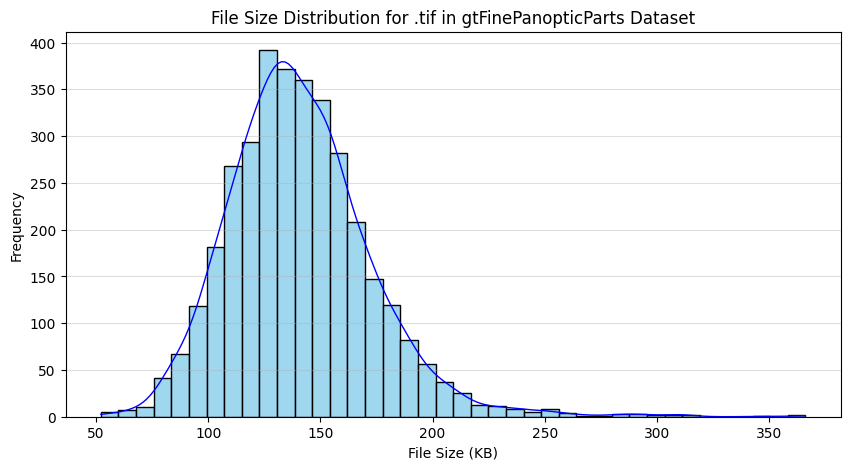

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


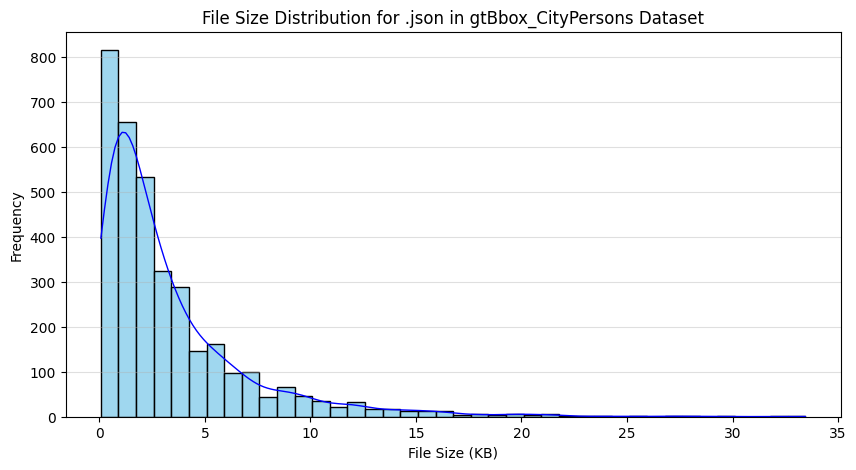

In [41]:
# Function to calculate file sizes for specific file types
def get_file_sizes_for_types(directory, file_types):
    file_sizes_by_type = {file_type: [] for file_type in file_types}
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            file_type = os.path.splitext(file)[-1].lower()
            if file_type in file_sizes_by_type:
                size = os.path.getsize(file_path) / 1e3  # Convert bytes to KB
                file_sizes_by_type[file_type].append(size)
    return file_sizes_by_type

# Define the file types to analyze
#gtFine_file_types = [".png", ".json"]
gtFinePano_file_type = [".tif"]
gtBbox_file_types = [".json"]

# Analyze file sizes for specific file types in both datasets
#gtFine_file_sizes_selected = get_file_sizes_for_types(gtFine_CorePath, gtFine_file_types)
gtFinePanoptic_file_sizes_selected = get_file_sizes_for_types(gtFinePano_Subdir, gtFinePano_file_type)
gtBbox_file_sizes_selected = get_file_sizes_for_types(gtBbox_Subdir, gtBbox_file_types)

# Function to plot file size distribution for specific file types
def plot_file_sizes_for_types(file_sizes_by_type, dataset_name):
    for file_type, sizes in file_sizes_by_type.items():
        plt.figure(figsize=(10, 5))
        sns.histplot(sizes, bins=40, kde=True, alpha=0.8, color='skyblue')
        ax = plt.gca()
        ax.lines[0].set_color('blue')  # Change KDE line color to red
        ax.lines[0].set_linewidth(1)  # Optional: Change line thickness
        plt.xlabel("File Size (KB)")
        plt.ylabel("Frequency")
        plt.title(f"File Size Distribution for {file_type} in {dataset_name}")
        plt.grid(axis="y", alpha=0.40)
        plt.show()

# Plot file size distribution for gtFine dataset
# plot_file_sizes_for_types(gtFine_file_sizes_selected, "gtFine Dataset")
# print("\n")
# Plot file size distribution for gtFinePanopticParts dataset
plot_file_sizes_for_types(gtFinePanoptic_file_sizes_selected, "gtFinePanopticParts Dataset")
print("\n")
# Plot file size distribution for gtBbox_CityPersons dataset
plot_file_sizes_for_types(gtBbox_file_sizes_selected, "gtBbox_CityPersons Dataset")

In [42]:
# Parse a JSON annotation file function
def parse_json_file(json_path):
    with open(json_path, 'r') as file:
        data = json.load(file)
    print("Keys in JSON file:", data.keys())
    return data

# Create a list of all JSON files from gtFine
def get_json_files(directory):
    json_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.json'):
                json_files.append(os.path.join(root, file))
    return json_files

gtBbox_json_files = get_json_files(gtBbox_Subdir)

Randomly Selected JSON file: /kaggle/input/city-persone/gtBbox_cityPersons_trainval/gtBboxCityPersons/train/tubingen/tubingen_000000_000019_gtBboxCityPersons.json
Keys in JSON file: dict_keys(['imgHeight', 'imgWidth', 'objects'])
Corresponding TIF file: /kaggle/input/city-persone/gtFinePanopticParts_trainval/gtFinePanopticParts/train/tubingen/tubingen_000000_000019_gtFinePanopticParts.tif


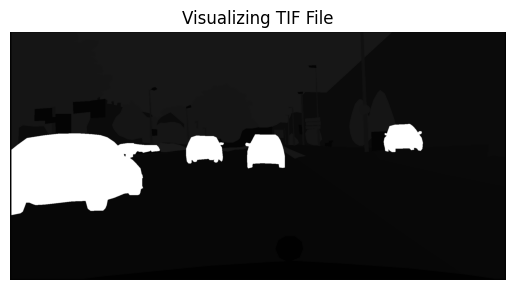

In [43]:
# Randomly select a JSON file from gtFine
if not gtBbox_json_files:
    print("No JSON files found in gtFine dataset.")
else:
    sample_json = random.choice(gtBbox_json_files)
    print(f"Randomly Selected JSON file: {sample_json}")
    sample_gtBbox_data = parse_json_file(sample_json)

    # Derive the corresponding .tif file path in gtFinePanopticParts
    json_filename = os.path.basename(sample_json)
    tif_filename = json_filename.replace('_gtBboxCityPersons.json', '_gtFinePanopticParts.tif')
    #gtBbox_json_filename = json_filename.replace('_gtFine_polygons.json', '_gtBboxCityPersons.json')

    # gtBbox_jsonFilePath = None
    # for root, _, files in os.walk(gtBbox_Subdir):
    #     for file in files:
    #         if file == gtBbox_json_filename:
    #             gtBbox_jsonFilePath = os.path.join(root, file)
    #             sample_gtBbox_data = parse_json_file(gtBbox_jsonFilePath)
    #             print(f"Corresponding .json from gtBbox_cityPersons file: {gtBbox_jsonFilePath}")
    #             break

    tif_file_path = None
    for root, _, files in os.walk(gtFinePano_Subdir):
        for file in files:
            if file == tif_filename:
                tif_file_path = os.path.join(root, file)
                break
        if tif_file_path:
            break

    # Visualize the .tif file if it exists
    if tif_file_path:
        print(f"Corresponding TIF file: {tif_file_path}")
        tif_image = Image.open(tif_file_path)
        plt.imshow(tif_image)
        plt.title("Visualizing TIF File")
        plt.axis('off')  # Turn off axis for better visualization
        plt.show()
    else:
        print(f"No corresponding TIF file found for {sample_json}")

In [44]:
sample_gtBbox_data

{'imgHeight': 1024,
 'imgWidth': 2048,
 'objects': [{'instanceId': 0,
   'bbox': [1469, 310, 14, 20],
   'bboxVis': [1469, 310, 14, 20],
   'label': 'ignore'}]}

In [45]:
def count_labels_with_details(data):
    # Dictionary to store label details
    label_details = defaultdict(list)

    for obj in data["objects"]:
        label_details[obj["label"]].append(obj)

    # Generate results
    result = {}
    for label, objects in label_details.items():
        unique_instance_ids = set(obj["instanceId"] for obj in objects)
        result[label] = {
            "count": len(unique_instance_ids),
            "details": objects
        }

    return result

label_summary = count_labels_with_details(sample_gtBbox_data)

# Print or process the results
for label, details in label_summary.items():
    print(f"Label: {label}")
    print(f"Count: {details['count']}")
    print("Details:")
    for obj in details["details"]:
        print(obj)

Label: ignore
Count: 1
Details:
{'instanceId': 0, 'bbox': [1469, 310, 14, 20], 'bboxVis': [1469, 310, 14, 20], 'label': 'ignore'}


### Bounding box analysis from json files

In [46]:
def analyze_class_distribution(json_files):
    class_counts = Counter()
    for file in json_files:
        with open(file, 'r') as f:
            data = json.load(f)
        for obj in data['objects']:
            class_counts[obj['label']] += 1
    return class_counts

# gtFine_class_distribution = analyze_class_distribution(gtFine_json_files)
# print(pd.DataFrame(gtFine_class_distribution.items(), columns=["Class", "Count"]))
# print("\n")
gtBbox_class_distribution = analyze_class_distribution(gtBbox_json_files)
class_distribution = pd.DataFrame(gtBbox_class_distribution.items(), columns=["Class", "Count"])
print(class_distribution)

            Class  Count
0      pedestrian  19683
1  person (other)    504
2          ignore   8399
3           rider   2189
4  sitting person   1217
5    person group   1573


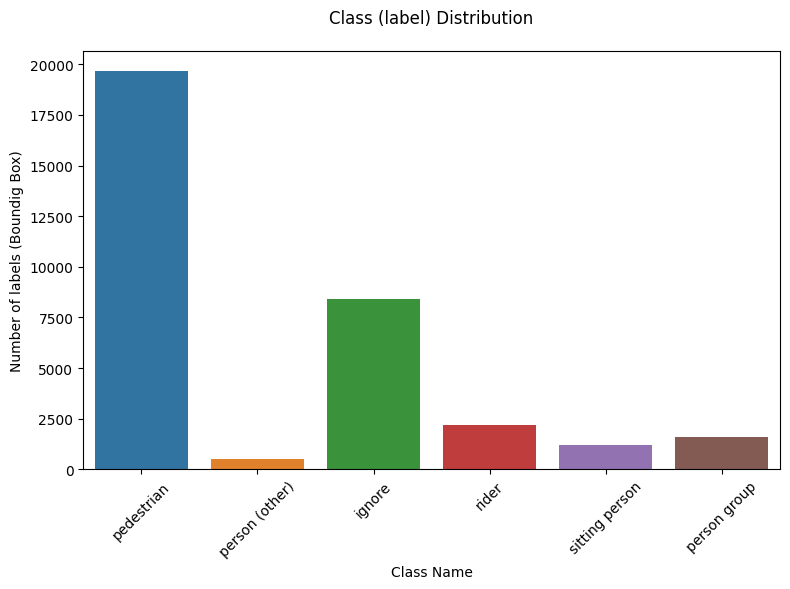

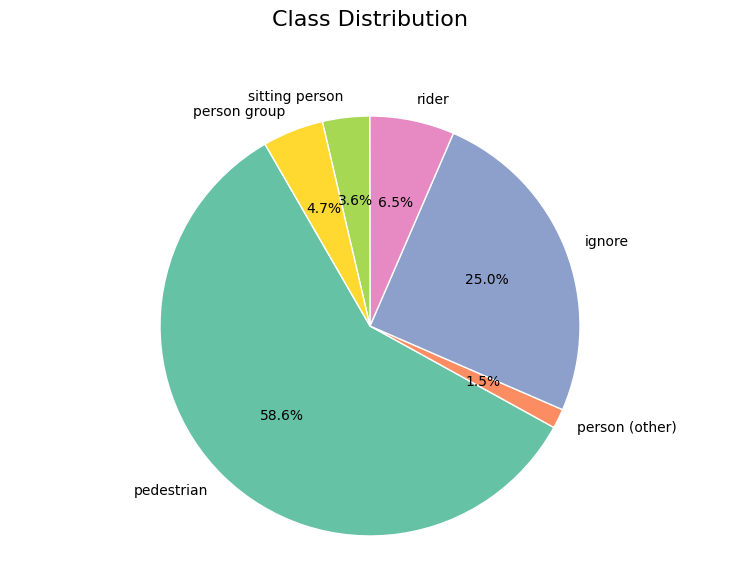

In [47]:
# Class (Label) disriburion
plt.figure(figsize=(8, 6))
sns.barplot(x=class_distribution['Class'], y=class_distribution['Count'])
plt.xticks(rotation=45)
plt.title('Class (label) Distribution', pad=20)
plt.xlabel('Class Name')
plt.ylabel('Number of labels (Boundig Box)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))  # Increase figure size for better clarity

# Improved aesthetics and readability
plt.pie(
    class_distribution['Count'],
    labels=class_distribution['Class'],
    autopct='%1.1f%%',
    startangle=120,
    radius=1.3,
    colors=sns.color_palette('Set2'), #or another palette you like better.
    wedgeprops={'edgecolor': 'white'}, #add white lines between slices.
    textprops={'fontsize': 10} #adjust text size
)

plt.title('Class Distribution', fontsize=16, pad=50) #more concise title.
plt.axis('equal')  # Ensures the pie chart is circular

# Add space to the left and right of the pie chart
plt.subplots_adjust(left=0.1, right=1) # Adjust left and right parameters.

plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


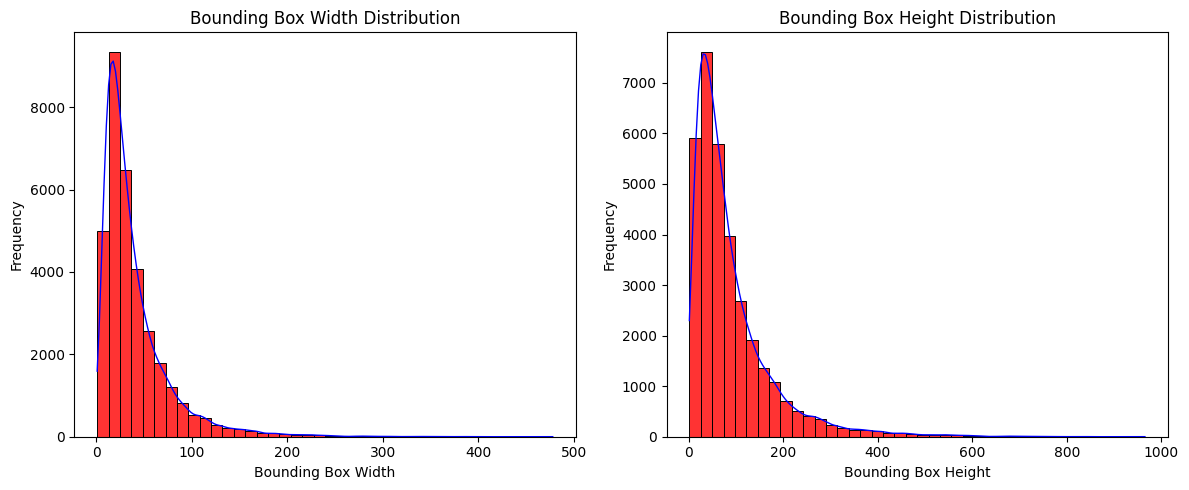

In [48]:
# Function to extract bounding box sizes from JSON files
def get_bbox_sizes(json_files):
    widths, heights = [], []
    
    for json_file in json_files:
        with open(json_file, 'r') as f:
            data = json.load(f)
            if "objects" in data:  # Adjust this key based on your JSON structure
                for obj in data["objects"]:
                    if "bbox" in obj:
                        x, y, w, h = obj["bbox"]  # Assuming bbox format [x, y, width, height]
                        widths.append(w)
                        heights.append(h)
    
    return widths, heights

# Get bounding box width and height distributions
widths, heights = get_bbox_sizes(gtBbox_json_files)

# Plot distributions
plt.figure(figsize=(12, 5))

# Width distribution
plt.subplot(1, 2, 1)
sns.histplot(widths, bins=40, kde=True, alpha=0.8, color='red')
ax = plt.gca()
ax.lines[0].set_color('blue')  # Change KDE line color to red
ax.lines[0].set_linewidth(1)  # Optional: Change line thickness
plt.xlabel("Bounding Box Width")
plt.ylabel("Frequency")
plt.title("Bounding Box Width Distribution")

# Height distribution
plt.subplot(1, 2, 2)
sns.histplot(heights, bins=40, kde=True, alpha=0.8, color='red')
ax = plt.gca()
ax.lines[0].set_color('blue')  # Change KDE line color to red
ax.lines[0].set_linewidth(1)  # Optional: Change line thickness
plt.xlabel("Bounding Box Height")
plt.ylabel("Frequency")
plt.title("Bounding Box Height Distribution")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


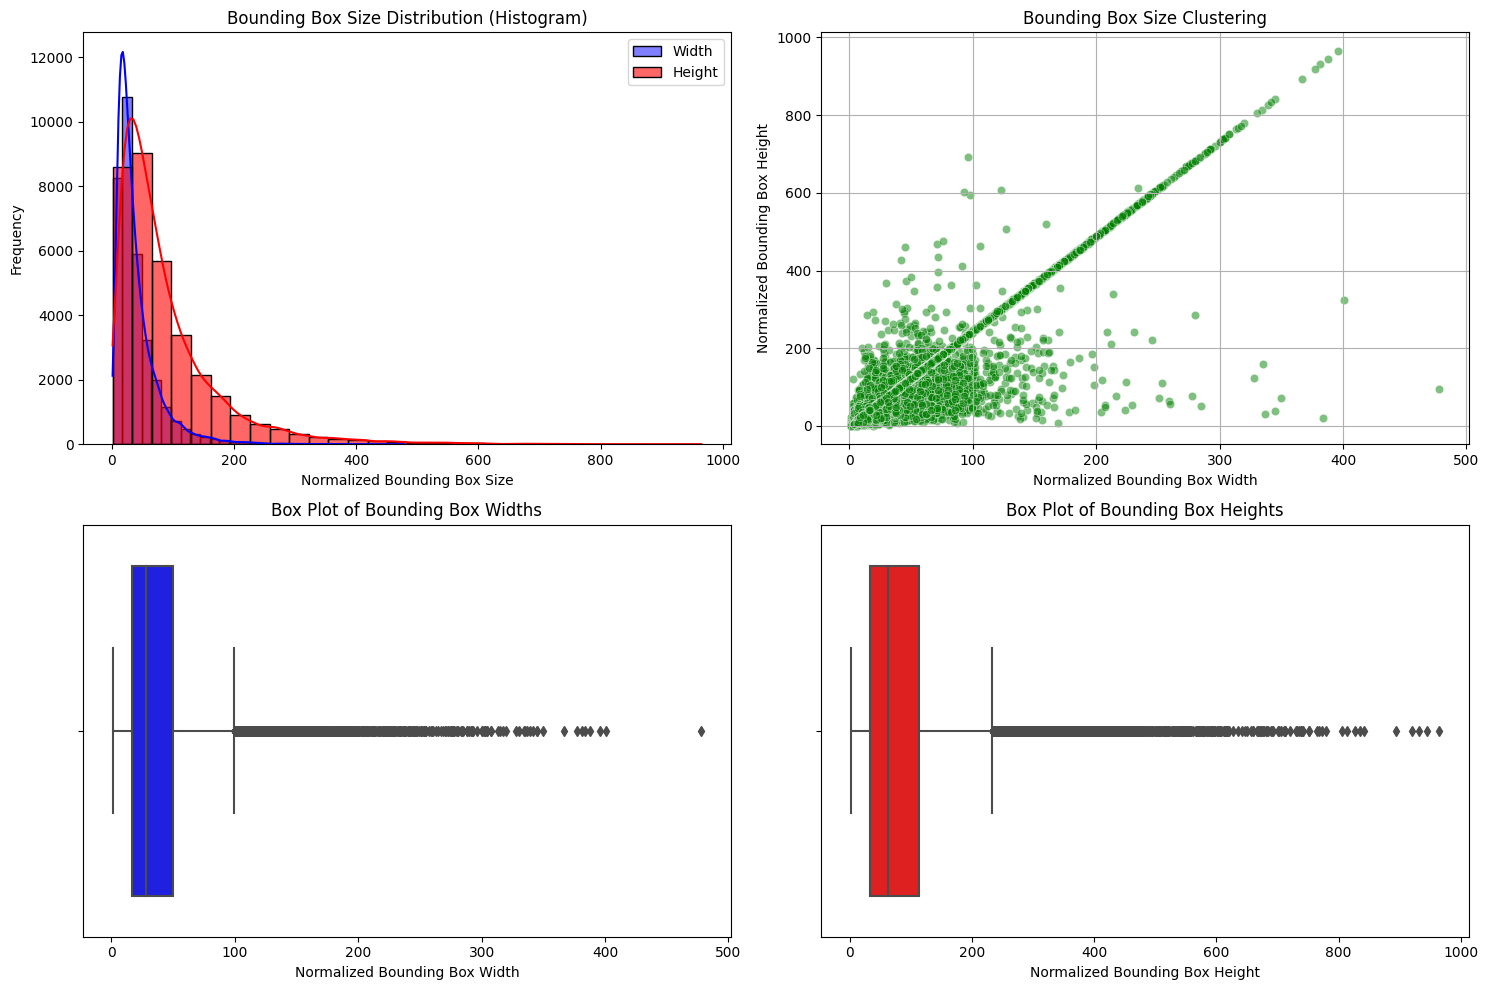

In [49]:
# Set up the figure
plt.figure(figsize=(15, 10))

# Histogram (Density Plot) for Widths and Heights
plt.subplot(2, 2, 1)
sns.histplot(widths, bins=30, kde=True, color="blue", label="Width")
sns.histplot(heights, bins=30, kde=True, color="red", label="Height", alpha=0.6)
plt.xlabel("Normalized Bounding Box Size")
plt.ylabel("Frequency")
plt.title("Bounding Box Size Distribution (Histogram)")
plt.legend()

# Scatter Plot for Bounding Box Clusters
plt.subplot(2, 2, 2)
sns.scatterplot(x=widths, y=heights, alpha=0.5, color="green")
plt.xlabel("Normalized Bounding Box Width")
plt.ylabel("Normalized Bounding Box Height")
plt.title("Bounding Box Size Clustering")
plt.grid(True)

# Box Plot for Bounding Box Widths
plt.subplot(2, 2, 3)
sns.boxplot(x=widths, color="blue")
plt.xlabel("Normalized Bounding Box Width")
plt.title("Box Plot of Bounding Box Widths")

# Box Plot for Bounding Box Heights
plt.subplot(2, 2, 4)
sns.boxplot(x=heights, color="red")
plt.xlabel("Normalized Bounding Box Height")
plt.title("Box Plot of Bounding Box Heights")

plt.tight_layout()
plt.show()

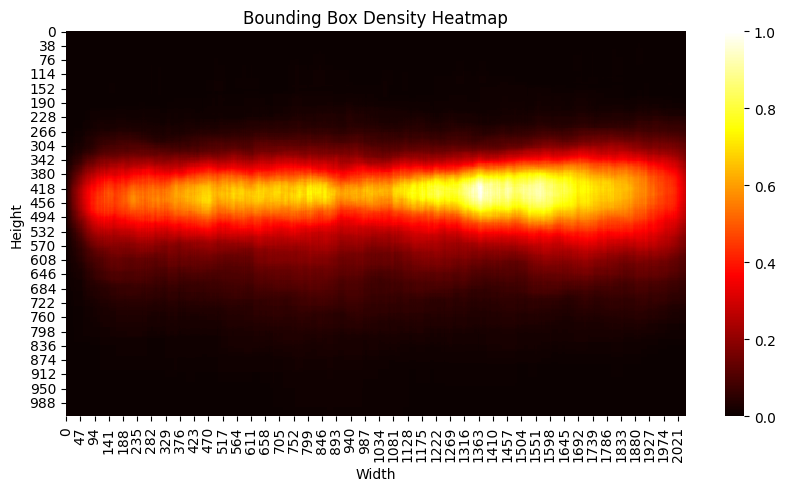

In [60]:
from tqdm import tqdm

# # Path to JSON files
# gtBbox_json_files = "path_to_json_files"

# Image dimensions (assuming all images have the same resolution)
IMG_HEIGHT = 1024
IMG_WIDTH = 2048

# Initialize heatmap
heatmap = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.float32)

# List to store aspect ratios
aspect_ratios = []
                        
# Function to process JSON files
def process_json_files(json_files):
    
    for json_file in json_files:
        with open((json_file), 'r') as f:
            data = json.load(f)
            for obj in data["objects"]:
                if obj["label"] == "pedestrian":  # Filter only pedestrians
                    x, y, w, h = obj["bbox"]
                    heatmap[y:y+h, x:x+w] += 1  # Accumulate heatmap
                    
                    if h > 0:  # Avoid division by zero
                        aspect_ratios.append(w / h)

# Process the dataset
process_json_files(gtBbox_json_files)

# Normalize the heatmap
heatmap /= heatmap.max()

# Plot heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(heatmap, cmap='hot', cbar=True)
plt.title("Bounding Box Density Heatmap")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


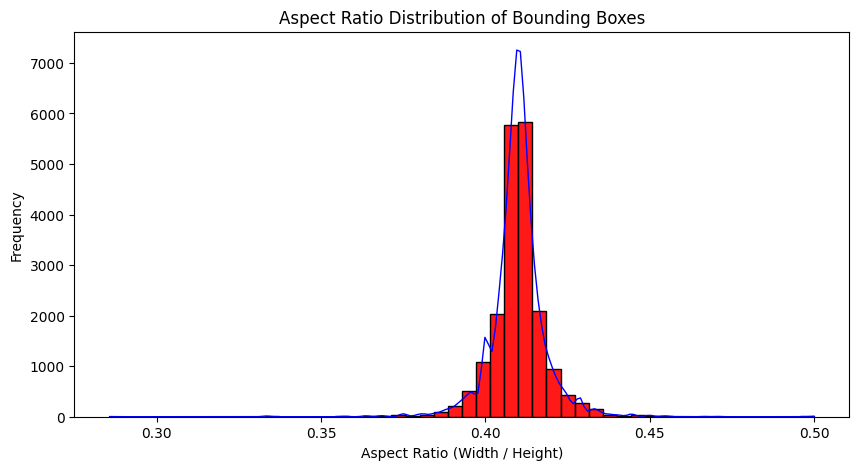

In [59]:
# Plot aspect ratio distribution
plt.figure(figsize=(10, 5))
sns.histplot(aspect_ratios, bins=50, kde=True, alpha=0.9, color='red')
ax = plt.gca()
ax.lines[0].set_color('blue')  # Change KDE line color to red
ax.lines[0].set_linewidth(1)  # Optional: Change line thickness
plt.xlabel("Aspect Ratio (Width / Height)")
plt.ylabel("Frequency")
plt.title("Aspect Ratio Distribution of Bounding Boxes")
plt.show()